In [1]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest
from CP2LFI.scores import LambdaScore

from clover import Scores
from clover import LocartSplit

In [2]:
err = {}
alpha = 0.05

# First simulation

Let $\theta$ be the parameter of interest and $\lambda(\theta) = F(\theta) - \hat{F}(\theta)$, $F$ being the cummulative distribution of an $\text{exp}(1)$ and $\hat{F}$ the empirical cumulative distribution the test statistic.

In [3]:
# o df_melted que retorna é só para printar as distribuicoes dos 
# lambdas com histplots e ver que elas mudam conforme theta

def generate_parameters(thetas, N, iters):
    values = pd.DataFrame()
    ## Parametros para arvore
    lambdas = []
    thetas_ = []
    ##
    for theta in thetas:
        diff = []
        theoretical = np.e**(-theta)
        for i in range(iters):
            exp = np.random.exponential(1/theta, N)
            empirical = (len([i for i in exp if i > 1])/len(exp))
            diff.append(abs(theoretical - empirical))
            lambdas.append(abs(theoretical - empirical))
            thetas_.append(theta)
        values[f"{theta}"] = diff
    df_melted = values.melt(var_name='theta')
    
    return lambdas, thetas_, df_melted

In [4]:
# defining statistic of interest as a new score using the Scores class 
class LambdaScore(Scores):
    def fit(self, X, y):
        return self

    def compute(self, thetas, lambdas):
        return lambdas

    def predict(self, thetas, cutoff):
        pred = np.vstack((thetas - cutoff, thetas + cutoff)).T
        return pred

In [5]:
def eval_coverage(quantiles):
    # theta = parametro
    # lambda = estatistica de teste
    # Lambda: |P_teorica(exp > 1) - P_empirica(exp > 1)|
    j = 0
    err = 0
    err_each = np.zeros(len(thetas))
    # computando erro padrao tambem
    for theta in thetas:
        theoretical = np.e**(-theta)
        lambdas_ = []
        for i in range(iters):
            distr = np.random.exponential(1/theta, N)
            empirical = len([i for i in distr if i > 1])/len(distr)
            diff = abs(theoretical - empirical)
            lambdas_.append(diff)
        alpha = len([i for i in lambdas_ if i >= quantiles[j]])/len(lambdas_)
        print(f"alpha for theta={theta} : {alpha} --- quantile: {quantiles[j]}")
        err += abs(alpha - 0.05)
        err_each[j] = abs(alpha - 0.05)
        j += 1
    print(f"mean absolute error: {err/j}")
    standard_error = np.std(err_each)
    print(f"standard error: {standard_error/np.sqrt(j)}")
    return [err/j, standard_error/np.sqrt(j)]

In [6]:
# isso foi usado em um experimento
def params_with_random_thetas(thetas, N):
    chosen_thetas = np.random.choice(thetas, N)
    lambdas = []
    thetas_ = []
    ##
    for theta in chosen_thetas:
        theoretical = np.e**(-theta)
        exp = np.random.exponential(1/theta, 10000)
        empirical = len([i for i in exp if i > 1])/len(exp)
        lambdas.append(abs(theoretical - empirical))
        thetas_.append(theta)
        
    return lambdas, thetas_

In [7]:
# Fica a vontade pra mudar isso aqui se quiser brincar
thetas = np.arange(0.5, 7, 0.5)
N = 10000
iters = 10000

np.random.seed(1250)
lambdas, thetas_, df_melted = generate_parameters(thetas, N, iters)

*df_melted* is the dataset with simulated $\lambda$ values for each value of $\theta$:

In [8]:
df_melted.head(10)

,theta,value
0,0.5,0.000369
1,0.5,0.003531
2,0.5,0.008069
3,0.5,0.003431
4,0.5,0.004531
5,0.5,0.004569
6,0.5,0.000669
7,0.5,0.009131
8,0.5,0.002969
9,0.5,0.005231


Implementing naive quantile estimation and prediction for any theta grid:

In [9]:
def train_naive_quantile(df_melted, thetas, alpha):
    quantiles = {}
    for theta in thetas:
        quantiles[theta] = np.quantile(list(df_melted[df_melted["theta"] == str(theta)].value), 1 - alpha)
    return quantiles

def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list

We want to obtain, for each $\theta$ a cutoff $C_{\theta}$ to build:
$$R(\mathcal{D}) = \{\theta \in \Theta: \lambda(\theta, \mathcal{D}) \geq C_{\theta} \} ,$$
such that:
$$\mathbb{P}_{\mathcal{D}|\theta}(\theta \in R(\mathcal{D})) \geq 1 - \alpha \quad \forall \theta \in \Theta.$$

# Naive estimator

Naive estimation of each cutoff

In [ ]:
# isso aqui eh o que eu to chamando de naive. Basicamente pega o
# parametro e tira o quantil dele. usei o df_melted pq era mais facil
# por algum motivo que nao consigo lembrar de cabeça agora
# naive = [
#     np.quantile(list(df_melted[df_melted["theta"] == str(theta)].value), 0.95)
#    for theta in thetas
# ]

naive_quantiles = train_naive_quantile(df_melted, thetas = thetas, alpha = alpha)
naive = predict_naive_quantile(thetas, naive_quantiles)

In [ ]:
err["err_naive"] = eval_coverage(naive)

alpha for theta=0.5 : 0.055 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0488 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0497 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0532 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0576 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0517 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.0536 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.047 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.0532 --- quantile: 0.002008996538242309
alpha for theta=5.0 : 0.0512 --- quantile: 0.0016379469990854684
alpha for theta=5.5 : 0.0596 --- quantile: 0.0012132285615359317
alpha for theta=6.0 : 0.059 --- quantile: 0.0009787521766663593
alpha for theta=6.5 : 0.0741 --- quantile: 0.000703439192977573
mean absolute error: 0.00559230769230769
standard error: 0.0016826107334411324


# Pinball oriented Regression Tree
Fitting a regression tree that uses the pinball loss for partitioning the data:

In [ ]:
# se colocar o boosting com 1 iteracao, ele vira uma arvore
# e o quantile loss eh o pinball. ref: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
model = GradientBoostingRegressor(
    loss = "quantile", alpha = .95, min_samples_leaf = 100, n_estimators = 1, max_depth = None
)

model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.95, loss='quantile', max_depth=None,
                          min_samples_leaf=100, n_estimators=1)

testing first a locart way of obtaining the cutoffs (pinball-LOCART):

In [ ]:
model.apply(thetas.reshape(-1, 1))

array([[ 3.],
       [ 4.],
       [ 5.],
       [ 7.],
       [ 9.],
       [11.],
       [13.],
       [15.],
       [16.],
       [16.],
       [16.],
       [16.],
       [16.]])

Obtaining quantiles in the LOCART manner:

In [ ]:
leaves = np.unique(model.apply(thetas.reshape(-1, 1)))
quantiles = {}
for leaf in leaves:
    indices = model.apply(model_thetas)
    selected_lambdas = model_lambdas[indices == leaf]
    n = selected_lambdas.shape[0]
    quantiles[leaf]  = np.quantile(selected_lambdas, q=np.ceil((n + 1) * (1 - 0.05)) / n)
idxs = model.apply(thetas.reshape(-1, 1))
list_gb_quantiles = [quantiles[idx] for idx in idxs.reshape(-1)]

In [ ]:
list_gb_quantiles

[0.009530659712633449,
 0.009479441171442338,
 0.008230160148429838,
 0.0066352832366126935,
 0.005284998623898807,
 0.004312931632136051,
 0.003302616577681494,
 0.0026843611112658157,
 0.0014910034617576905,
 0.0014910034617576905,
 0.0014910034617576905,
 0.0014910034617576905,
 0.0014910034617576905]

Obtaining errors for these quantiles:

In [ ]:
err["err_pinball_locart"] = eval_coverage(list_gb_quantiles)

alpha for theta=0.5 : 0.0505 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0503 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0479 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0557 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0564 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0476 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.054 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.0482 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.1655 --- quantile: 0.0014910034617576905
alpha for theta=5.0 : 0.0663 --- quantile: 0.0014910034617576905
alpha for theta=5.5 : 0.0168 --- quantile: 0.0014910034617576905
alpha for theta=6.0 : 0.0033 --- quantile: 0.0014910034617576905
alpha for theta=6.5 : 0.0002 --- quantile: 0.0014910034617576905
mean absolute error: 0.0219
standard error: 0.008850293345855397


testing now cutoffs obtained from direct predictions of the model:

In [ ]:
model = HistGradientBoostingRegressor(
    loss = "quantile", quantile = .95, min_samples_leaf = 100, max_iter=1
)

model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

quantiles = model.predict(thetas.reshape(-1, 1))
quantiles

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.00650547, 0.00650364, 0.00637939, 0.00621593, 0.00608091,
       0.0059837 , 0.00588267, 0.00581397, 0.00569861, 0.00569861,
       0.00569861, 0.00569861, 0.00569861])

In [ ]:
err["err_reg"] = eval_coverage(quantiles)

alpha for theta=0.5 : 0.1709 --- quantile: 0.006505472229893283
alpha for theta=1.0 : 0.1772 --- quantile: 0.006503639788343396
alpha for theta=1.5 : 0.1161 --- quantile: 0.006379390243786953
alpha for theta=2.0 : 0.0712 --- quantile: 0.006215934582291208
alpha for theta=2.5 : 0.0296 --- quantile: 0.006080906121019819
alpha for theta=3.0 : 0.0064 --- quantile: 0.005983699421843543
alpha for theta=3.5 : 0.0007 --- quantile: 0.005882667916398088
alpha for theta=4.0 : 0.0 --- quantile: 0.005813970147503357
alpha for theta=4.5 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=5.0 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=5.5 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=6.0 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=6.5 : 0.0 --- quantile: 0.005698611558721391
mean absolute error: 0.057592307692307707
standard error: 0.00851158251257996


## Testing MSE-LOCART

In [ ]:
# fitting locart to the new synthetic class
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

In [ ]:
err["err_locart"] = eval_coverage(list_locart_quantiles)

alpha for theta=0.5 : 0.0484 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0516 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.05 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0547 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0503 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0445 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.0523 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.0475 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.053 --- quantile: 0.002008996538242309
alpha for theta=5.0 : 0.0514 --- quantile: 0.0016379469990854684
alpha for theta=5.5 : 0.063 --- quantile: 0.0012132285615359317
alpha for theta=6.0 : 0.0548 --- quantile: 0.0009787521766663593
alpha for theta=6.5 : 0.0725 --- quantile: 0.000703439192977573
mean absolute error: 0.00486153846153846
standard error: 0.0016695865789352656


## Regressor - random

Generating 1000 random thetas from the grid to compute the metrics of both the gradient boosting tree and the MSE-locart:

In [ ]:
# aqui, a gente gera N (=1000) thetas aleatoriamente entre
# os possiveis valores do grid e computa as metricas
lambdas_r, thetas_r = params_with_random_thetas(thetas, 1000)

Obtaining metrics first for the gradient boosting unique tree:

In [ ]:
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95, max_iter=1
)

model_thetas = np.array(thetas_r).reshape(-1, 1)
model_lambdas = np.array(lambdas_r).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(loss='quantile', max_iter=1, quantile=0.95)

In [ ]:
quantiles = model.predict(thetas.reshape(-1, 1))
quantiles

array([0.00633479, 0.00631502, 0.0062397 , 0.00604401, 0.00606857,
       0.0057016 , 0.0057016 , 0.0057016 , 0.0057016 , 0.0057016 ,
       0.0057016 , 0.0057016 , 0.0057016 ])

In [ ]:
err["err_reg_random"] = eval_coverage(quantiles)

alpha for theta=0.5 : 0.1925 --- quantile: 0.006334786563000806
alpha for theta=1.0 : 0.1847 --- quantile: 0.006315015003451892
alpha for theta=1.5 : 0.1302 --- quantile: 0.006239704576894481
alpha for theta=2.0 : 0.0765 --- quantile: 0.0060440149270052125
alpha for theta=2.5 : 0.0256 --- quantile: 0.0060685705779764555
alpha for theta=3.0 : 0.0098 --- quantile: 0.00570160115277289
alpha for theta=3.5 : 0.0005 --- quantile: 0.00570160115277289
alpha for theta=4.0 : 0.0 --- quantile: 0.00570160115277289
alpha for theta=4.5 : 0.0 --- quantile: 0.00570160115277289
alpha for theta=5.0 : 0.0 --- quantile: 0.00570160115277289
alpha for theta=5.5 : 0.0 --- quantile: 0.00570160115277289
alpha for theta=6.0 : 0.0 --- quantile: 0.00570160115277289
alpha for theta=6.5 : 0.0 --- quantile: 0.00570160115277289
mean absolute error: 0.061384615384615406
standard error: 0.009809232736667634


Obtaining the metrics for locart:

In [ ]:
# fitting locart to the new synthetic class
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 50)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

In [ ]:
err["err_locart_random"] = eval_coverage(list_locart_quantiles)

alpha for theta=0.5 : 0.0564 --- quantile: 0.009379409712633482
alpha for theta=1.0 : 0.029 --- quantile: 0.010542781050779897
alpha for theta=1.5 : 0.0231 --- quantile: 0.009479881221487699
alpha for theta=2.0 : 0.0498 --- quantile: 0.006741569086661329
alpha for theta=2.5 : 0.005 --- quantile: 0.0074858320336822
alpha for theta=3.0 : 0.031 --- quantile: 0.004688038240274154
alpha for theta=3.5 : 0.0381 --- quantile: 0.0035059815393709863
alpha for theta=4.0 : 0.019 --- quantile: 0.0031872182541229552
alpha for theta=4.5 : 0.0654 --- quantile: 0.0018915966401033368
alpha for theta=5.0 : 0.0614 --- quantile: 0.0015387879061260178
alpha for theta=5.5 : 0.0497 --- quantile: 0.0012157075349155317
alpha for theta=6.0 : 0.0425 --- quantile: 0.0009826561669860107
alpha for theta=6.5 : 0.0716 --- quantile: 0.0006996587312530109
mean absolute error: 0.01673846153846154
standard error: 0.0033898131149118268


## 20 iters in each theta

Making less iterations for each theta and testing the gradient boosting, naive and so on:

In [ ]:
# Aqui foi uma tentativa de fazer poucas iteracoes em cima de cada theta,
# que é algo mais proximo do que acontece na realidade
lambdas_few, thetas_few, _ = generate_parameters(thetas, N, 20)

In [ ]:
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95, max_iter=1
)

model_thetas = np.array(thetas_few).reshape(-1, 1)
model_lambdas = np.array(lambdas_few).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(loss='quantile', max_iter=1, quantile=0.95)

In [ ]:
quantiles = model.predict(thetas.reshape(-1, 1))
quantiles

array([0.00595127, 0.00627218, 0.00591232, 0.00561421, 0.00559368,
       0.00528434, 0.00528434, 0.00528434, 0.00528434, 0.00528434,
       0.00528434, 0.00528434, 0.00528434])

In [ ]:
err["err_reg_few_iters"] = eval_coverage(quantiles)

alpha for theta=0.5 : 0.2121 --- quantile: 0.005951271655975811
alpha for theta=1.0 : 0.1923 --- quantile: 0.006272180735542627
alpha for theta=1.5 : 0.1538 --- quantile: 0.005912316616754129
alpha for theta=2.0 : 0.104 --- quantile: 0.005614206521407959
alpha for theta=2.5 : 0.0409 --- quantile: 0.0055936809062637075
alpha for theta=3.0 : 0.0154 --- quantile: 0.005284337729609411
alpha for theta=3.5 : 0.0025 --- quantile: 0.005284337729609411
alpha for theta=4.0 : 0.0002 --- quantile: 0.005284337729609411
alpha for theta=4.5 : 0.0 --- quantile: 0.005284337729609411
alpha for theta=5.0 : 0.0 --- quantile: 0.005284337729609411
alpha for theta=5.5 : 0.0 --- quantile: 0.005284337729609411
alpha for theta=6.0 : 0.0 --- quantile: 0.005284337729609411
alpha for theta=6.5 : 0.0 --- quantile: 0.005284337729609411
mean absolute error: 0.06563076923076924
standard error: 0.01159887458637517


Testing also for MSE-locart:

In [ ]:
# fitting locart to the new synthetic class
# changing minimal sample leaves to a new strategic value
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 5)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

In [ ]:
err["err_locart_few"] = eval_coverage(list_locart_quantiles)

alpha for theta=0.5 : 0.0214 --- quantile: 0.011365619094593767
alpha for theta=1.0 : 0.0184 --- quantile: 0.011365619094593767
alpha for theta=1.5 : 0.0083 --- quantile: 0.011365619094593767
alpha for theta=2.0 : 0.0735 --- quantile: 0.006046244260783349
alpha for theta=2.5 : 0.0262 --- quantile: 0.006046244260783349
alpha for theta=3.0 : 0.1138 --- quantile: 0.0034275448175940036
alpha for theta=3.5 : 0.0446 --- quantile: 0.0034275448175940036
alpha for theta=4.0 : 0.0094 --- quantile: 0.0034275448175940036
alpha for theta=4.5 : 0.0015 --- quantile: 0.0034275448175940036
alpha for theta=5.0 : 0.0886 --- quantile: 0.0013695530009145325
alpha for theta=5.5 : 0.0328 --- quantile: 0.0013695530009145325
alpha for theta=6.0 : 0.0063 --- quantile: 0.0013695530009145325
alpha for theta=6.5 : 0.0008 --- quantile: 0.0013695530009145325
mean absolute error: 0.035092307692307693
standard error: 0.00412907803137299


# Conformal Loforest

In [ ]:
model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas)

loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 100)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

loforest_cutoffs

array([0.00953066, 0.00947944, 0.00823016, 0.00663528, 0.005285  ,
       0.00431293, 0.00330262, 0.00268436, 0.002009  , 0.00163795,
       0.00121323, 0.00097875, 0.00070344])

In [ ]:
err["err_conformal_loforest"] = eval_coverage(loforest_cutoffs)

alpha for theta=0.5 : 0.0486 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0486 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0521 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0523 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0545 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0479 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.0551 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.0508 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.0598 --- quantile: 0.002008996538242309
alpha for theta=5.0 : 0.0522 --- quantile: 0.0016379469990854684
alpha for theta=5.5 : 0.0589 --- quantile: 0.0012132285615359317
alpha for theta=6.0 : 0.0542 --- quantile: 0.0009787521766663593
alpha for theta=6.5 : 0.0684 --- quantile: 0.000703439192977573
mean absolute error: 0.0048615384615384605
standard error: 0.0013188904455195122


Testing the random grid:

In [ ]:
model_thetas = np.array(thetas_r).reshape(-1, 1)
model_lambdas = np.array(lambdas_r).reshape(-1, 1)

loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 100)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

loforest_cutoffs

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([0.00913951, 0.00913951, 0.00823246, 0.0059261 , 0.00468826,
       0.00468826, 0.00468826, 0.00468826, 0.00208553, 0.00208553,
       0.00132199, 0.00132199, 0.00132199])

In [ ]:
err["err_conformal_loforest_random"] = eval_coverage(loforest_cutoffs)

alpha for theta=0.5 : 0.0576 --- quantile: 0.009139509270155511
alpha for theta=1.0 : 0.057 --- quantile: 0.009139509270155511
alpha for theta=1.5 : 0.0452 --- quantile: 0.008232460803696337
alpha for theta=2.0 : 0.0852 --- quantile: 0.005926099837758356
alpha for theta=2.5 : 0.0896 --- quantile: 0.0046882568329617924
alpha for theta=3.0 : 0.0343 --- quantile: 0.0046882568329617924
alpha for theta=3.5 : 0.006 --- quantile: 0.0046882568329617924
alpha for theta=4.0 : 0.0002 --- quantile: 0.0046882568329617924
alpha for theta=4.5 : 0.0516 --- quantile: 0.0020855278163685272
alpha for theta=5.0 : 0.0108 --- quantile: 0.0020855278163685272
alpha for theta=5.5 : 0.0328 --- quantile: 0.00132198532636369
alpha for theta=6.0 : 0.0074 --- quantile: 0.00132198532636369
alpha for theta=6.5 : 0.0002 --- quantile: 0.00132198532636369
mean absolute error: 0.02723846153846154
standard error: 0.004915998980042582


Testing the small grid:

In [ ]:
model_thetas = np.array(thetas_few).reshape(-1, 1)
model_lambdas = np.array(lambdas_few).reshape(-1, 1)


loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 5)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

loforest_cutoffs

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([0.01238547, 0.01136562, 0.00878135, 0.00604624, 0.00574461,
       0.00551733, 0.00380876, 0.00279458, 0.003091  , 0.00178805,
       0.00178677, 0.00133289, 0.00100344])

In [ ]:
err["err_conformal_loforest_few"] = eval_coverage(loforest_cutoffs)

alpha for theta=0.5 : 0.0114 --- quantile: 0.012385469112870234
alpha for theta=1.0 : 0.0181 --- quantile: 0.011365619094593767
alpha for theta=1.5 : 0.0361 --- quantile: 0.00878134785899164
alpha for theta=2.0 : 0.0772 --- quantile: 0.006046244260783349
alpha for theta=2.5 : 0.0369 --- quantile: 0.005744607174595659
alpha for theta=3.0 : 0.0115 --- quantile: 0.005517334617694451
alpha for theta=3.5 : 0.0221 --- quantile: 0.003808764970687576
alpha for theta=4.0 : 0.0359 --- quantile: 0.0027945825229488772
alpha for theta=4.5 : 0.0045 --- quantile: 0.0030910034617576913
alpha for theta=5.0 : 0.028 --- quantile: 0.0017880508274796033
alpha for theta=5.5 : 0.0055 --- quantile: 0.0017867714384640684
alpha for theta=6.0 : 0.0064 --- quantile: 0.0013328859137119006
alpha for theta=6.5 : 0.0099 --- quantile: 0.001003439192977573
mean absolute error: 0.03083846153846154
standard error: 0.003219789740305988


In [ ]:
err["err_pinball_loforest"] = eval_coverage(loforest_cutoffs)

# Conformal loforest oriented by pinball loss

In [10]:
model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas)

qloforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
qloforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 50, objective = "quantile", colsample_bynode = 1, max_features = 1)
qloforest_cutoffs = qloforest_object.compute_cutoffs(thetas.reshape(-1, 1))

qloforest_cutoffs

array([0.00953066, 0.00947944, 0.00823016, 0.00663528, 0.00796934,
       0.004815  , 0.00268707, 0.00268707, 0.00219738, 0.00219738,
       0.00219738, 0.00219738, 0.00219738])

In [11]:
err["err_conformal_qloforest"] = eval_coverage(qloforest_cutoffs)

alpha for theta=0.5 : 0.055 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0488 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0497 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0532 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0039 --- quantile: 0.007969340287366622
alpha for theta=3.0 : 0.0277 --- quantile: 0.004815001376101205
alpha for theta=3.5 : 0.1212 --- quantile: 0.0026870683678639484
alpha for theta=4.0 : 0.0431 --- quantile: 0.0026870683678639484
alpha for theta=4.5 : 0.0338 --- quantile: 0.0021973834223185072
alpha for theta=5.0 : 0.008 --- quantile: 0.0021973834223185072
alpha for theta=5.5 : 0.0008 --- quantile: 0.0021973834223185072
alpha for theta=6.0 : 0.0 --- quantile: 0.0021973834223185072
alpha for theta=6.5 : 0.0 --- quantile: 0.0021973834223185072
mean absolute error: 0.027969230769230767
standard error: 0.006460525420728553


# Boosting

Making use of the boosting algorithm to obtain the cutoff via a quantile regression

In [ ]:
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95
)

model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(loss='quantile', quantile=0.95)

In [ ]:
model.n_iter_

53

In [ ]:
boosting_quantiles = model.predict(thetas.reshape(-1, 1))
boosting_quantiles

array([0.00951789, 0.00946686, 0.00822227, 0.00663339, 0.00528818,
       0.00430301, 0.00330881, 0.00269731, 0.00202339, 0.00165305,
       0.0012325 , 0.00100204, 0.00072469])

In [ ]:
err["err_boosting"] = eval_coverage(boosting_quantiles)

alpha for theta=0.5 : 0.0509 --- quantile: 0.009517885565404586
alpha for theta=1.0 : 0.0501 --- quantile: 0.00946685945750348
alpha for theta=1.5 : 0.0457 --- quantile: 0.008222272110878684
alpha for theta=2.0 : 0.0545 --- quantile: 0.006633387314497852
alpha for theta=2.5 : 0.0528 --- quantile: 0.005288175858973282
alpha for theta=3.0 : 0.0488 --- quantile: 0.004303013061496541
alpha for theta=3.5 : 0.0511 --- quantile: 0.003308810354772356
alpha for theta=4.0 : 0.044 --- quantile: 0.002697309207068315
alpha for theta=4.5 : 0.0512 --- quantile: 0.0020233929319321583
alpha for theta=5.0 : 0.0408 --- quantile: 0.0016530456026055012
alpha for theta=5.5 : 0.0486 --- quantile: 0.00123250305627594
alpha for theta=6.0 : 0.0472 --- quantile: 0.0010020419070685567
alpha for theta=6.5 : 0.0488 --- quantile: 0.0007246870331545556
mean absolute error: 0.0028230769230769234
standard error: 0.0006870013605279974


## Random - Boosting

Repeating the random thetas experiment:

In [ ]:
# boosting com os parametros gerados aleatoriamente
model_r = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95
)

In [ ]:
model_thetas = np.array(thetas_r).reshape(-1, 1)
model_lambdas = np.array(lambdas_r).reshape(-1, 1)
model_r.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(loss='quantile', quantile=0.95)

In [ ]:
model_r.n_iter_

100

In [ ]:
boosting_quantiles_r = model_r.predict(thetas.reshape(-1, 1))
boosting_quantiles_r

array([0.00914058, 0.00894287, 0.00818978, 0.00623294, 0.00647849,
       0.00461665, 0.00340006, 0.0030394 , 0.00180907, 0.00145617,
       0.00117344, 0.00094448, 0.00056116])

In [ ]:
err["err_boosting_random"] = eval_coverage(boosting_quantiles_r)

alpha for theta=0.5 : 0.0597 --- quantile: 0.00914057690383788
alpha for theta=1.0 : 0.0646 --- quantile: 0.008942866559951539
alpha for theta=1.5 : 0.0497 --- quantile: 0.008189782297880236
alpha for theta=2.0 : 0.0716 --- quantile: 0.006232937776896031
alpha for theta=2.5 : 0.0208 --- quantile: 0.00647848776428406
alpha for theta=3.0 : 0.0329 --- quantile: 0.004616650655146988
alpha for theta=3.5 : 0.0459 --- quantile: 0.0034000614403316563
alpha for theta=4.0 : 0.0227 --- quantile: 0.0030393998005053646
alpha for theta=4.5 : 0.0782 --- quantile: 0.0018090736622344364
alpha for theta=5.0 : 0.0758 --- quantile: 0.0014561710521714614
alpha for theta=5.5 : 0.0719 --- quantile: 0.0011734427000124885
alpha for theta=6.0 : 0.0524 --- quantile: 0.000944478226890295
alpha for theta=6.5 : 0.1548 --- quantile: 0.0005611568324452675
mean absolute error: 0.023615384615384614
standard error: 0.00703348580874071


## 20 iters in each theta - Boosting

In [ ]:
# boosting com poucas observacoes sobre cada theta
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95,
)

model_thetas = np.array(thetas_few).reshape(-1, 1)
model_lambdas = np.array(lambdas_few).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(loss='quantile', quantile=0.95)

In [ ]:
model.n_iter_

100

In [ ]:
quantiles = model.predict(thetas.reshape(-1, 1))
quantiles

array([0.00919342, 0.01239099, 0.00882378, 0.00577641, 0.00558608,
       0.00492352, 0.00278027, 0.00265441, 0.00274259, 0.0017383 ,
       0.00150412, 0.00130084, 0.00072386])

In [ ]:
err["err_boosting_few_iters"] = eval_coverage(quantiles)

alpha for theta=0.5 : 0.0582 --- quantile: 0.00919342425185533
alpha for theta=1.0 : 0.0105 --- quantile: 0.012390993913237138
alpha for theta=1.5 : 0.0373 --- quantile: 0.00882378180140067
alpha for theta=2.0 : 0.0876 --- quantile: 0.005776413735249767
alpha for theta=2.5 : 0.0427 --- quantile: 0.005586083816467919
alpha for theta=3.0 : 0.0216 --- quantile: 0.004923517746358238
alpha for theta=3.5 : 0.1042 --- quantile: 0.0027802676585627034
alpha for theta=4.0 : 0.0492 --- quantile: 0.002654408301393961
alpha for theta=4.5 : 0.008 --- quantile: 0.002742594277357665
alpha for theta=5.0 : 0.0311 --- quantile: 0.001738301331363586
alpha for theta=5.5 : 0.0211 --- quantile: 0.0015041194997289955
alpha for theta=6.0 : 0.0091 --- quantile: 0.0013008423245348634
alpha for theta=6.5 : 0.051 --- quantile: 0.0007238562075916346
mean absolute error: 0.02464615384615385
standard error: 0.004700668659279569


# Results:

First, we plot all of these results in an errorbar plot:

In [ ]:
for key, value in err.items():
    print(f"{key} = {value}")

err_naive = [0.00559230769230769, 0.0016826107334411324]
err_pinball_locart = [0.0219, 0.008850293345855397]
err_reg = [0.057592307692307707, 0.00851158251257996]
err_locart = [0.00486153846153846, 0.0016695865789352656]
err_reg_random = [0.061384615384615406, 0.009809232736667634]
err_locart_random = [0.01673846153846154, 0.0033898131149118268]
err_reg_few_iters = [0.06563076923076924, 0.01159887458637517]
err_locart_few = [0.035092307692307693, 0.00412907803137299]
err_conformal_loforest = [0.0048615384615384605, 0.0013188904455195122]
err_conformal_loforest_random = [0.02783076923076924, 0.004685182290005167]
err_conformal_loforest_few = [0.03083846153846154, 0.003219789740305988]
err_boosting = [0.0028230769230769234, 0.0006870013605279974]
err_boosting_random = [0.023615384615384614, 0.00703348580874071]
err_boosting_few_iters = [0.02464615384615385, 0.004700668659279569]


/tmp/ipykernel_105472/322675001.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


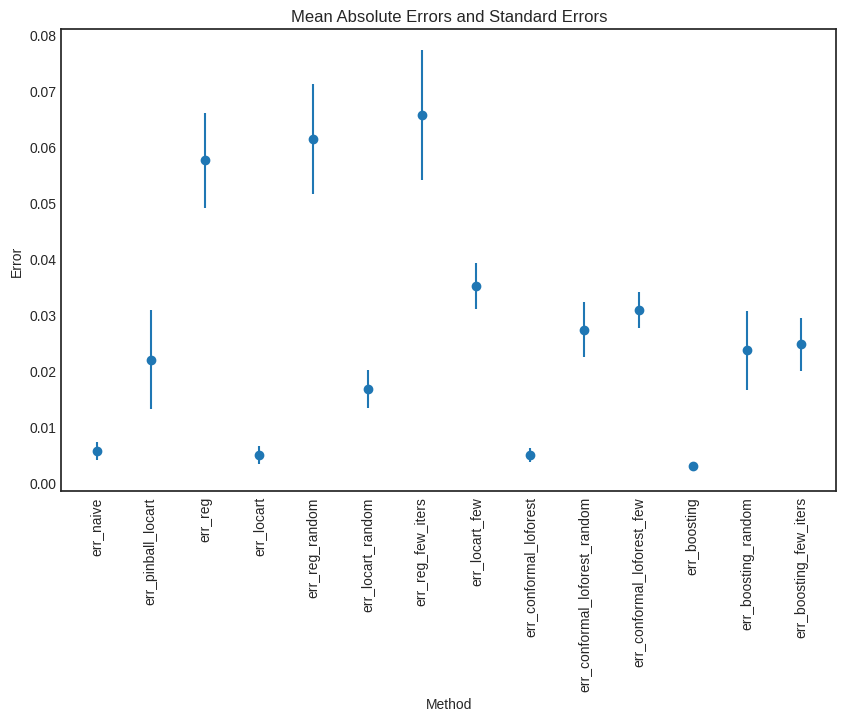

In [ ]:
# Use seaborn-white style
plt.style.use('seaborn-white')

# Extract keys and values from the dictionary
keys = list(err.keys())
values = list(err.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Comparing naive to locart, conformal loforest and boosting for out of grid points:

In [ ]:
def eval_coverage_new_grid(theta_grid, quantiles):
    # theta = parametro
    # lambda = estatistica de teste
    # Lambda: |P_teorica(exp > 1) - P_empirica(exp > 1)|
    j = 0
    err = 0
    err_each = np.zeros(theta_grid.shape[0])
    # computando erro padrao tambem
    for theta in theta_grid:
        theoretical = np.e**(-theta)
        lambdas_ = []
        for i in range(iters):
            distr = np.random.exponential(1/theta, N)
            empirical = len([i for i in distr if i > 1])/len(distr)
            diff = abs(theoretical - empirical)
            lambdas_.append(diff)
        alpha = len([i for i in lambdas_ if i >= quantiles[j]])/len(lambdas_)
        print(f"alpha for theta={theta} : {alpha} --- quantile: {quantiles[j]}")
        err += abs(alpha - 0.05)
        err_each[j] = abs(alpha - 0.05)
        j += 1
    print(f"mean absolute error: {err/j}")
    standard_error = np.std(err_each)
    print(f"standard error: {standard_error/np.sqrt(j)}")
    return [err/j, standard_error/np.sqrt(j)]

Generating random grid points:

In [ ]:
np.random.seed(1250)
random_theta_grid = np.random.uniform(0, 7, 20)
err_random_grid = {}

# model thetas for locart, loforest and boosting
model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas)

Obtaining the quantiles for each method: Locart, Loforest, Boosting and Naive.

In [ ]:
# naive quantiles
naive_quantiles = train_naive_quantile(df_melted, thetas = thetas, alpha = alpha)
naive = predict_naive_quantile(random_theta_grid, naive_quantiles)
err_random_grid["naive"] = eval_coverage_new_grid(random_theta_grid, naive)

# locart quantiles
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas)
idxs = locart_object.cart.apply(random_theta_grid.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]
err_random_grid["locart"] = eval_coverage_new_grid(random_theta_grid, list_locart_quantiles)

# loforest quantiles
loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 100)
loforest_cutoffs = loforest_object.compute_cutoffs(random_theta_grid.reshape(-1, 1))
err_random_grid["c-loforest"] = eval_coverage_new_grid(random_theta_grid, loforest_cutoffs)

# boosting quantiles
model = HistGradientBoostingRegressor(loss="quantile", quantile=.95)
model.fit(model_thetas, model_lambdas)
boosting_quantiles = model.predict(random_theta_grid.reshape(-1, 1))
err_random_grid["boosting"] = eval_coverage_new_grid(random_theta_grid, boosting_quantiles)

alpha for theta=0.30275232042893696 : 0.0274 --- quantile: 0.009530659712633449
alpha for theta=1.2411049560396177 : 0.0366 --- quantile: 0.009479441171442338
alpha for theta=0.4083525026586644 : 0.0431 --- quantile: 0.009530659712633449
alpha for theta=1.1196895413602677 : 0.043 --- quantile: 0.009479441171442338
alpha for theta=3.4200838573417056 : 0.0593 --- quantile: 0.003302616577681494
alpha for theta=1.9261873242851286 : 0.0571 --- quantile: 0.0066352832366126935
alpha for theta=1.830834771124082 : 0.0723 --- quantile: 0.0066352832366126935
alpha for theta=4.820033691255512 : 0.0707 --- quantile: 0.0016379469990854684
alpha for theta=5.262142812213676 : 0.0918 --- quantile: 0.0012132285615359317
alpha for theta=2.429114271837263 : 0.0627 --- quantile: 0.005284998623898807
alpha for theta=0.7075902889591793 : 0.0585 --- quantile: 0.009530659712633449
alpha for theta=2.25966809806648 : 0.0854 --- quantile: 0.005284998623898807
alpha for theta=5.3851792923277175 : 0.0778 --- quanti

Plotting results:

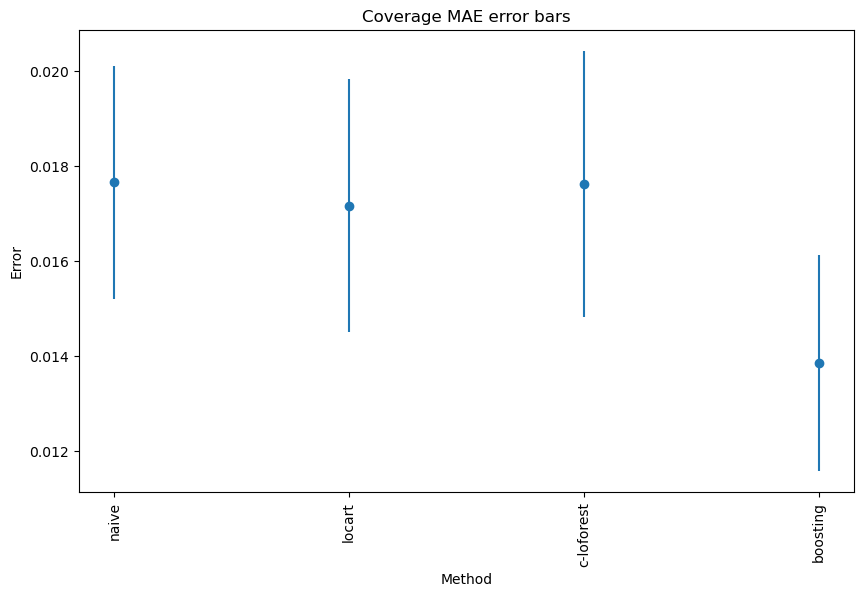

In [ ]:
# Extract keys and values from the dictionary
keys = list(err_random_grid.keys())
values = list(err_random_grid.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()